In [9]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [10]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [11]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [12]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [13]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [14]:
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649

In [15]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [16]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32360766 -2.98273191]


In [17]:
df_sim = df.copy()

df_sim

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [18]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

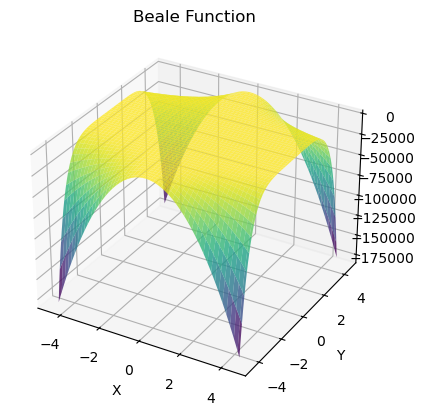

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Beale Function')

# Show the plot
plt.show()

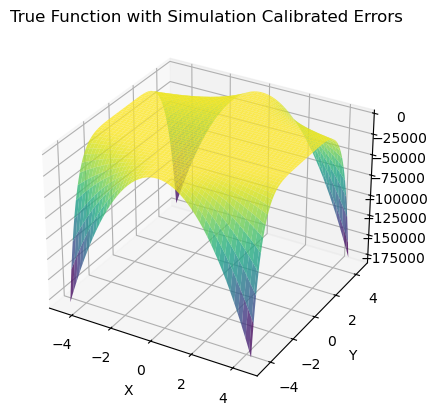

In [20]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [21]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [22]:
df_new = pd.DataFrame

In [23]:
obj_val_df = pd.DataFrame(columns=["Highest_Sim_Response", "Num_Points_In_df"])

In [24]:
round_val_df = pd.DataFrame(columns=["Highest_phy_Response", "Round_num"])

new_entry1 = pd.DataFrame({"Highest_phy_Response": [df['z'].max()],
                          "Round_num": [0]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [25]:
def perform_iteration(df, df2):
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=5,
        num_units=150,
        learning_rate=0.01,
        dropout_rate=0.2
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=200, batch_size=128, verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-4.5, 4.5, 100)
    x2_range = np.linspace(-4.5, 4.5, 100)
    bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    global obj_val_df
    # Append to tracking DataFrame
    new_entry = pd.DataFrame({
        "Highest_Sim_Response": [df2['sim_z'].max()],
        "Num_Points_In_df": [len(df)]
    })
    obj_val_df = pd.concat([obj_val_df, new_entry], ignore_index=True)

    return df, df2


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1626388.7500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1624770.1250
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1619147.3750
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1598383.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1549792.8750
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1407982.1250
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1225149.2500
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 808256.5000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 442061.5938
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 299325.2812
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 547600.5625
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 108751.5625
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 98957.2500
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 39313.1875
Epoch 15/200

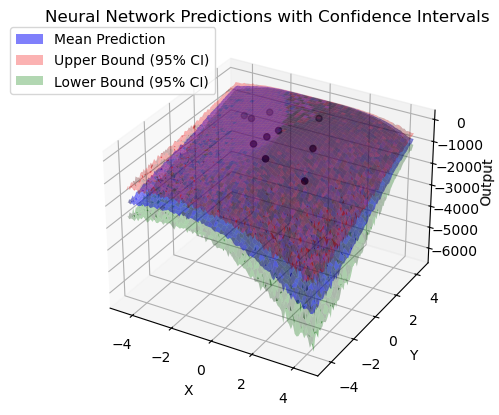

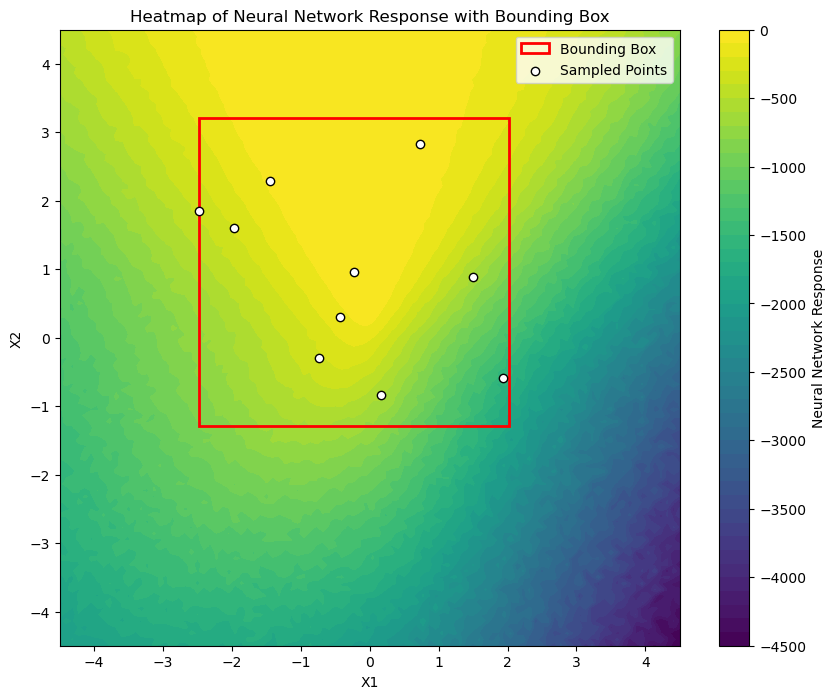

          x         y          z         a         b      sim_z      diff
8  1.932245 -0.588080  -3.511386  4.323608 -2.982732  -3.487490 -0.023896
2  1.498119  0.891655 -10.461906  4.323608 -2.982732 -10.260366 -0.201541
1  0.166843 -0.834087 -11.847968  4.323608 -2.982732 -11.830147 -0.017821
6 -1.967689  1.608288 -13.713344  4.323608 -2.982732 -13.910935  0.197591
9 -0.227273  0.954545 -14.531859  4.323608 -2.982732 -14.488660 -0.043199
           x         y            z         a         b        sim_z      diff
0  -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1   1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2  -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3  -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4  -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
5  -1.442324  2.296579  -195.150441  4.323608 -2.982732  -195.245493  0.095052
6  

In [26]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 556201.8750
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 554816.9375
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 548371.2500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 530604.4375
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 468129.6875
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 383436.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 278236.4062
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 286907.8750
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 260987.3594
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 184973.7031
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 177153.0156
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 156196.1406
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 180100.7656
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 123396.8359
Epoch 15/200
1/1 

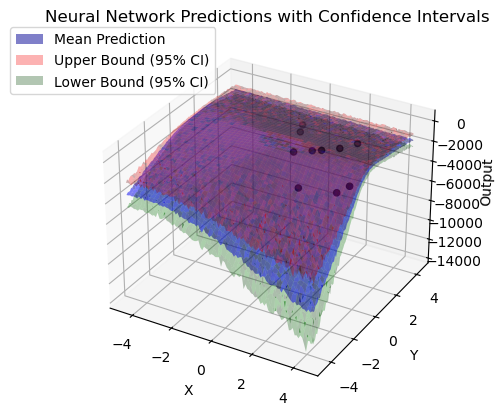

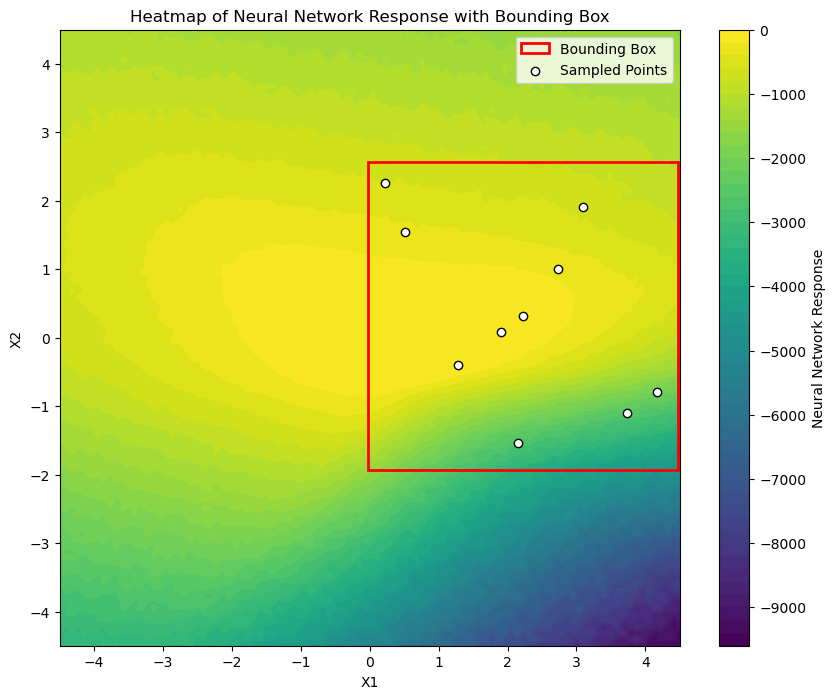

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 348218.0938
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 347485.1250
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 344091.0312
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 330675.4375
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 292234.2188
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 251024.8438
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 208976.9219
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 203577.8594
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 167984.2188
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 147206.5156
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 150297.7031
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 139851.9219
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 138653.1406
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 123391.0938
Epoch 15/200
1/1 

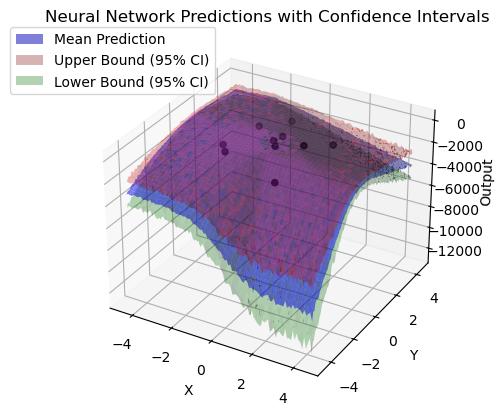

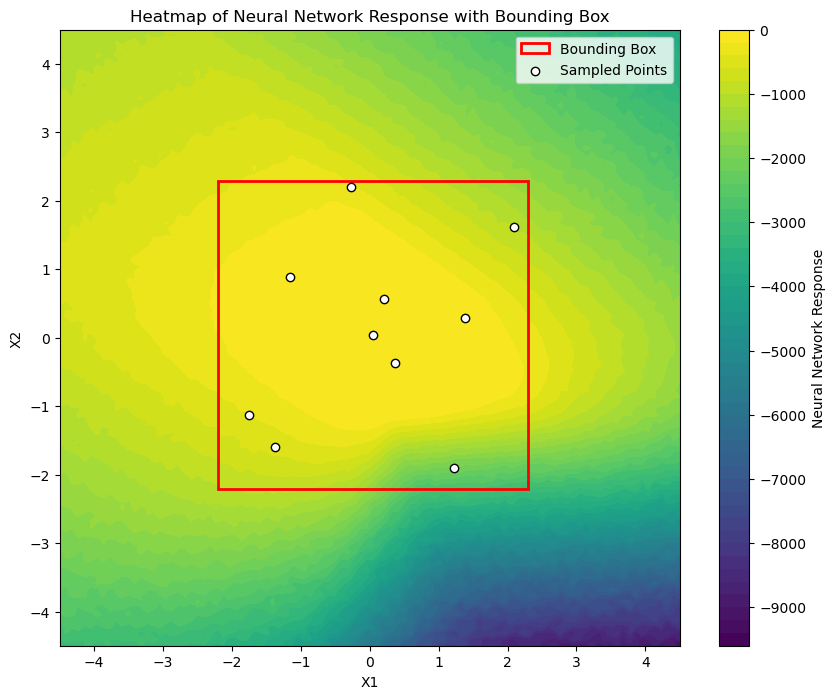

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 249975.3125
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 249261.9219
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 246362.8906
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 236921.3750
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 217987.6406
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 184459.4688
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 186948.2031
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 133489.7344
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 154399.3281
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 102229.7500
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 130234.0391
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 121570.6250
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 111417.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 100407.6484
Epoch 15/200
1/1 

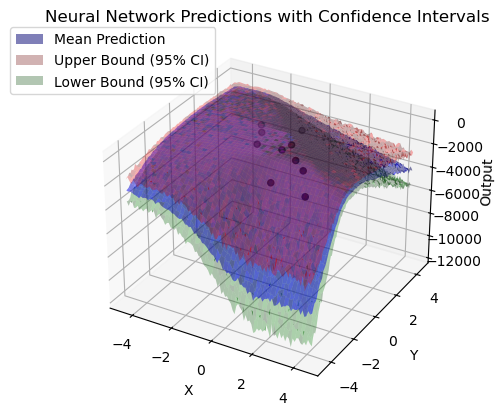

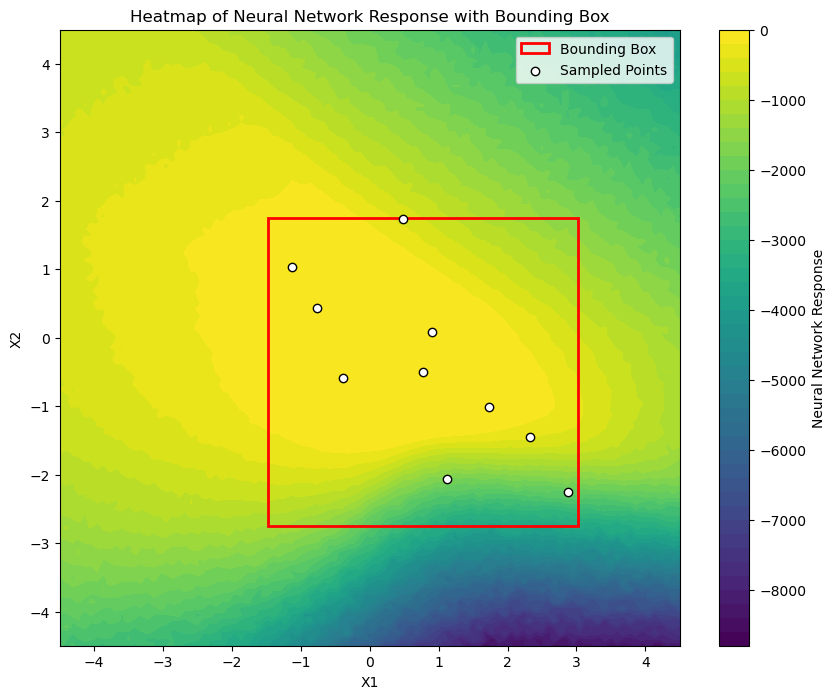

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 235979.3125
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 235222.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 231661.0938
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 221982.5625
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 196178.0938
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 161960.6562
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 178872.1562
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 150622.8438
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 141019.7344
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 115051.7109
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 119931.2188
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 109347.4141
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 100547.8750
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 102091.3906
Epoch 15/200
1/1 

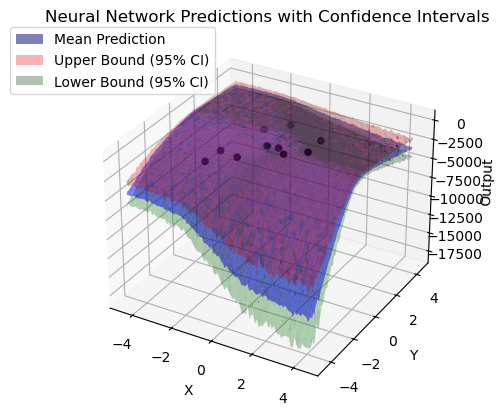

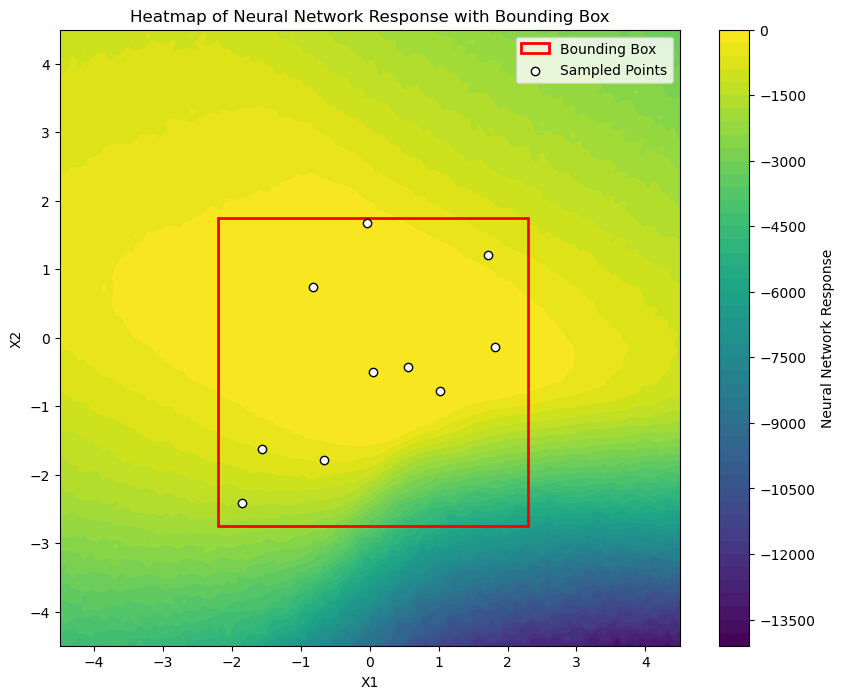

In [30]:
df_sim, df_new = perform_iteration(df_sim, df)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 213866.4531
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 213155.2656
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 209401.0469
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 198316.2188
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 172828.9531
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 150305.2031
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 146116.5781
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 125892.1328
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 110752.5234
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 109632.0703
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 102664.1641
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 100717.6250
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 101241.2266
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 92087.4609
Epoch 15/200
1/1 ━

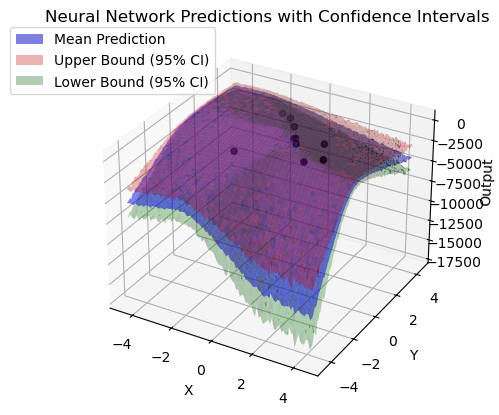

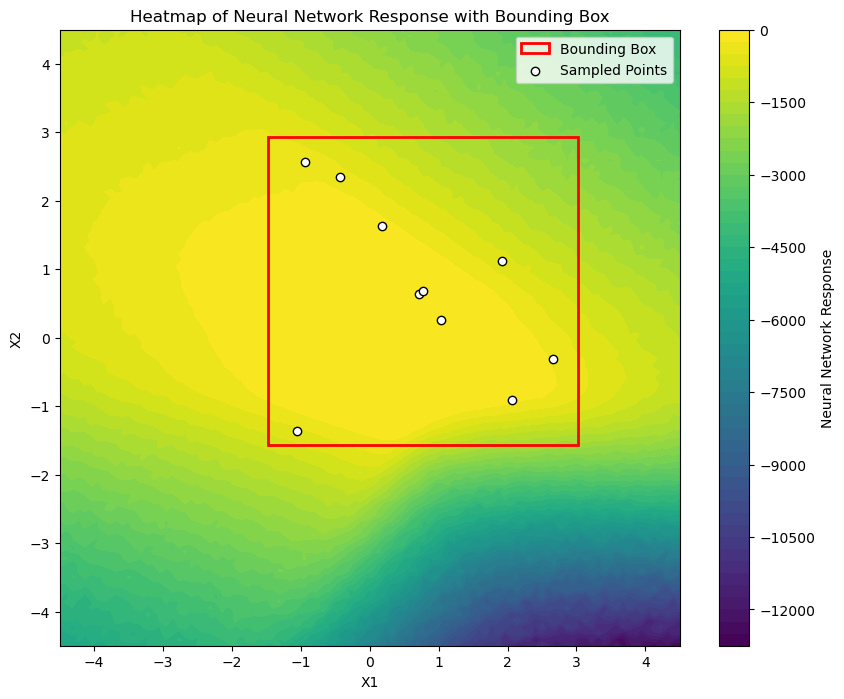

          x         y         z         a         b     sim_z      diff
5  2.657922 -0.309360 -3.921010  4.323608 -2.982732 -3.907621 -0.013389
4  1.031095  0.255834 -4.672443  4.323608 -2.982732 -4.758093  0.085650
6 -0.436436  2.354488 -7.865382  4.323608 -2.982732 -7.893059  0.027677
8  0.709160  0.634130 -9.236444  4.323608 -2.982732 -9.244412  0.007968
9  0.772727  0.681818 -9.315922  4.323608 -2.982732 -9.314497 -0.001425
           x         y            z         a         b        sim_z      diff
0  -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1   1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2  -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3  -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4  -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
..       ...       ...          ...       ...       ...          ...       ...
60  2.657922 -0

In [31]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

In [32]:
df_new

x         y         z         a         b     sim_z      diff
5  2.657922 -0.309360 -3.921010  4.323608 -2.982732 -3.907621 -0.013389
4  1.031095  0.255834 -4.672443  4.323608 -2.982732 -4.758093  0.085650
6 -0.436436  2.354488 -7.865382  4.323608 -2.982732 -7.893059  0.027677
8  0.709160  0.634130 -9.236444  4.323608 -2.982732 -9.244412  0.007968
9  0.772727  0.681818 -9.315922  4.323608 -2.982732 -9.314497 -0.001425

In [33]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [34]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.5171819410172759


In [35]:
df = pd.concat([df, df_new], ignore_index=True)
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
5  2.657922 -0.309360    -3.921010  4.323608 -2.982732    -3.907621 -0.013389
6  1.031095  0.255834    -4.672443  4.323608 -2.982732    -4.758093  0.085650
7 -0.436436  2.354488    -7.865382  4.323608 -2.982732    -7.893059  0.027677
8  0.709160  0.634130    -9.236444  4.323608 -2.982732    -9.244412  0.007968
9  0.772727  0.681818    -9.315922  4.323608 -2.982732    -9.314497 -0.001425

In [36]:
df = df.iloc[:, :-4]
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649
5  2.657922 -0.309360    -3.921010
6  1.031095  0.255834    -4.672443
7 -0.436436  2.354488    -7.865382
8  0.709160  0.634130    -9.236444
9  0.772727  0.681818    -9.315922

In [37]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.40212419 -3.09255751]


In [38]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X    Y    Z
0  3  0.5 -0.0

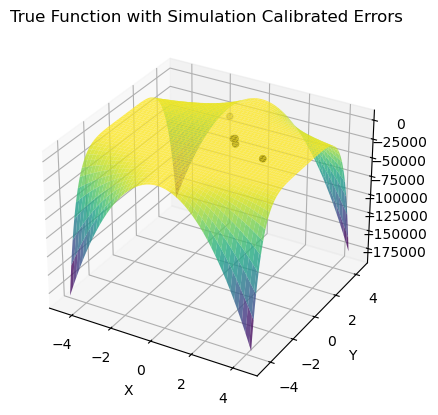

In [39]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [40]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new['z'].max()],
                          "Round_num": [1]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [41]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.402124 -3.092558 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.402124 -3.092558 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.402124 -3.092558  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.402124 -3.092558   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.402124 -3.092558   -70.288401  0.096751
5  2.657922 -0.309360    -3.921010  4.402124 -3.092558    -4.021214  0.100203
6  1.031095  0.255834    -4.672443  4.402124 -3.092558    -4.800469  0.128025
7 -0.436436  2.354488    -7.865382  4.402124 -3.092558    -7.899620  0.034238
8  0.709160  0.634130    -9.236444  4.402124 -3.092558    -9.274463  0.038019
9  0.772727  0.681818    -9.315922  4.402124 -3.092558    -9.347649  0.031727

In [42]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: 0.020090777573630668


In [43]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.402124 -3.092558 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.402124 -3.092558 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.402124 -3.092558  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.402124 -3.092558   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.402124 -3.092558   -70.288401  0.096751


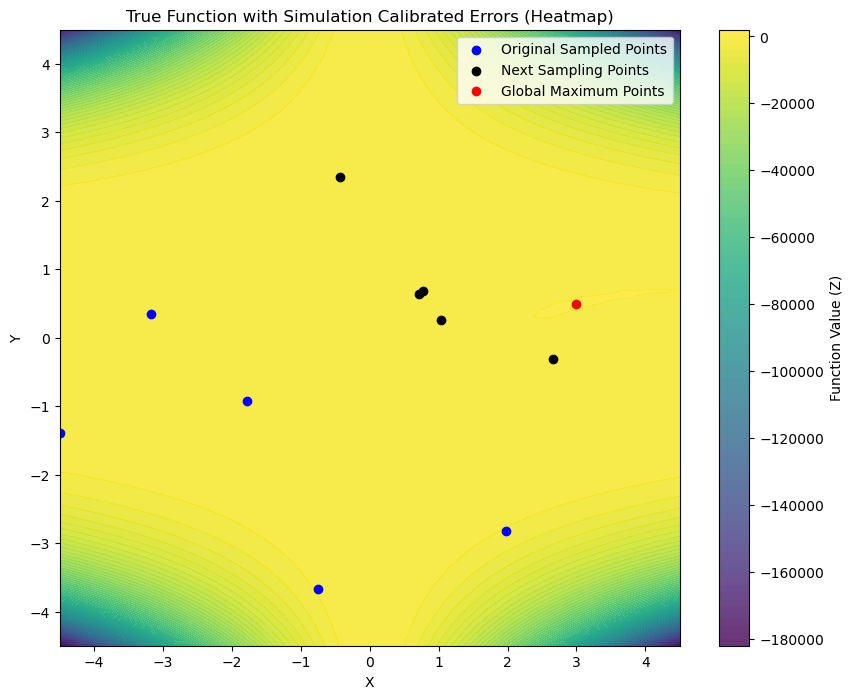

In [44]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [45]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 813607.4375
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 812172.8125
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 804347.6250
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 779659.1250
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 730453.3125
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 620352.9375
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 491878.9375
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 218908.0781
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 259003.1562
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 290929.3438
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 150942.0938
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 74403.7891
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 142571.8750
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 188358.4531
Epoch 15/200
1/1 ━

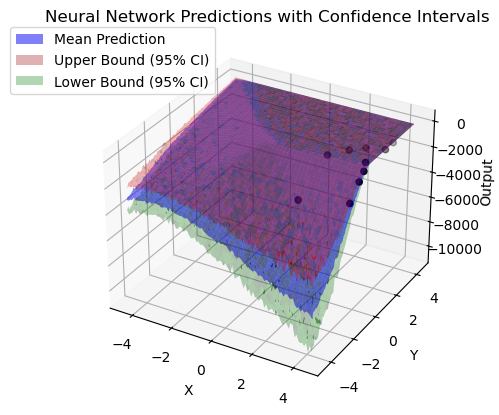

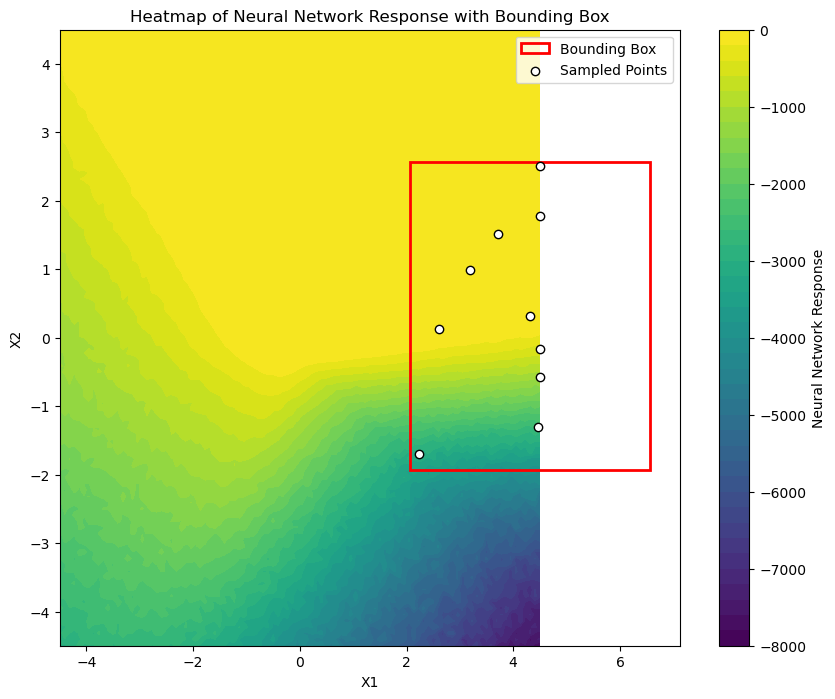

In [46]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1955520.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1954035.7500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1948640.2500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1924067.6250
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1864618.2500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1718270.6250
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1447074.1250
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1249793.5000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1518734.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1317323.6250
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1200772.8750
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1064677.3750
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1188545.7500
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1156776.6250
Epo

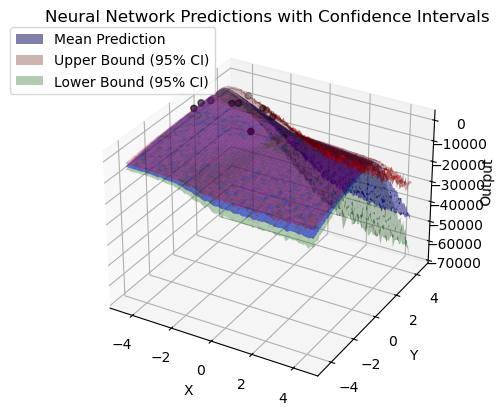

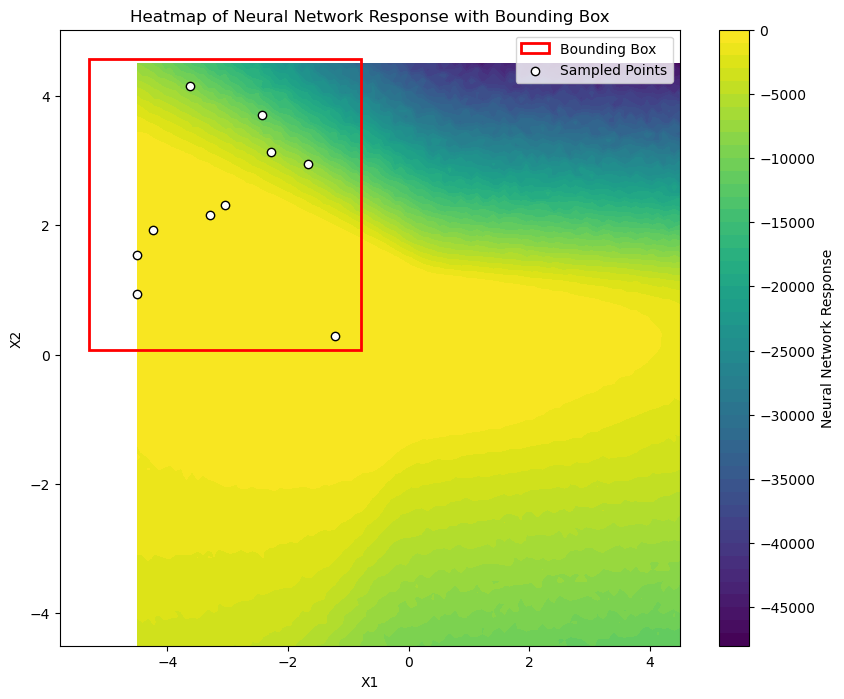

In [47]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 159846848.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 159823472.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 159708480.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 159287824.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 158357296.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 155924544.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 151820560.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 142590816.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 136452800.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 114509208.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 108614656.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 128766840.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 113119360.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

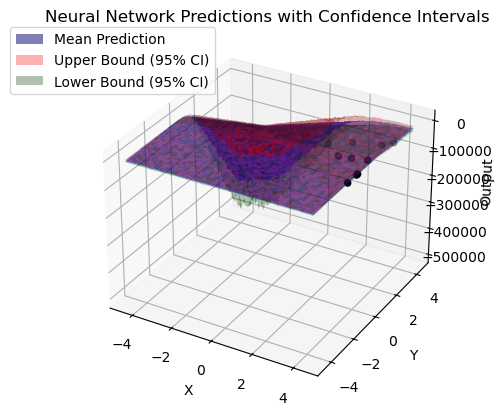

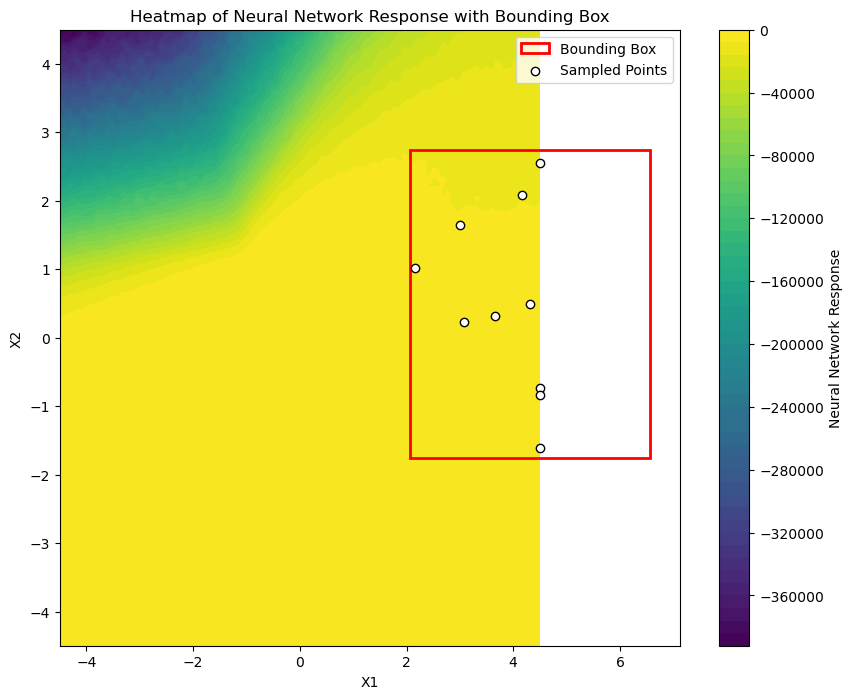

In [48]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 120885696.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 120875544.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 120808552.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 120610288.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 119925592.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 118644544.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 116490752.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 111727952.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 104138664.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 90263472.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 84646144.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 94104176.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 98856856.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - 

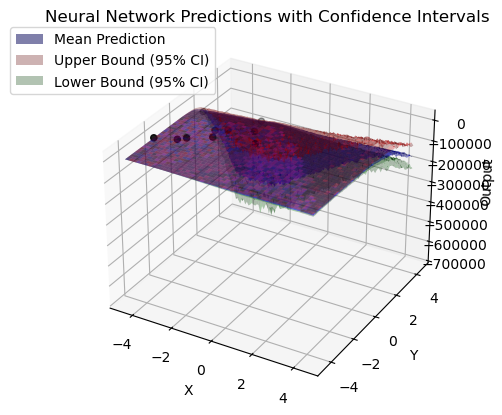

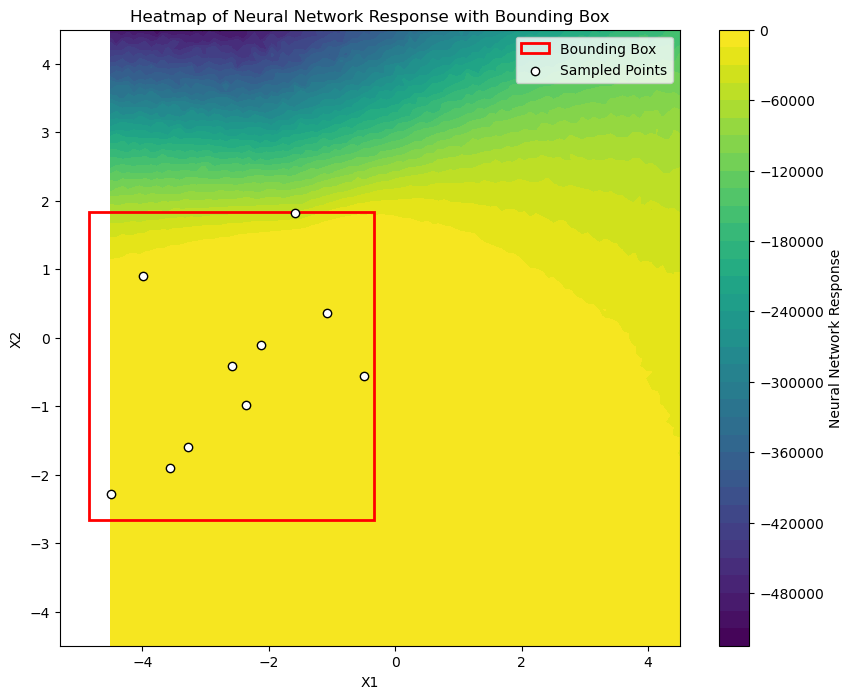

In [49]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 97103200.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 97093512.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 97065216.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 96953448.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 96695728.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 95707576.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 94299064.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 91423200.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 88731800.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 84469360.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 78876568.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 75802960.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 69822928.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 705

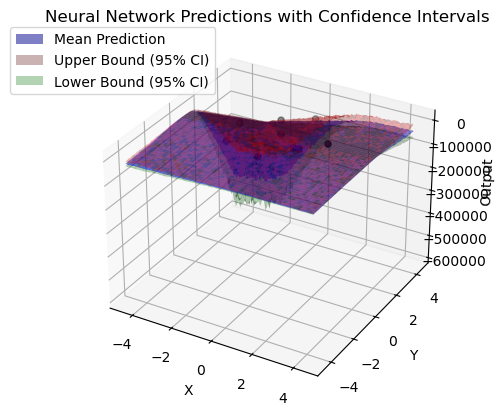

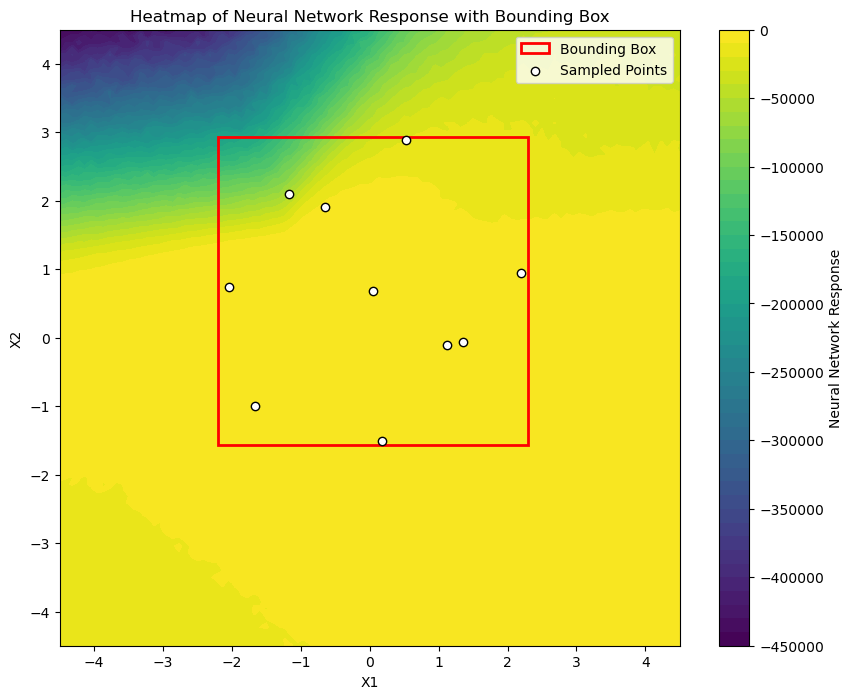

In [50]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 80919624.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 80904168.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 80825184.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 80550520.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 80037880.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 78966536.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 75836648.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 72283720.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 64878152.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 63800392.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 66306756.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 68749520.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 60781660.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 653

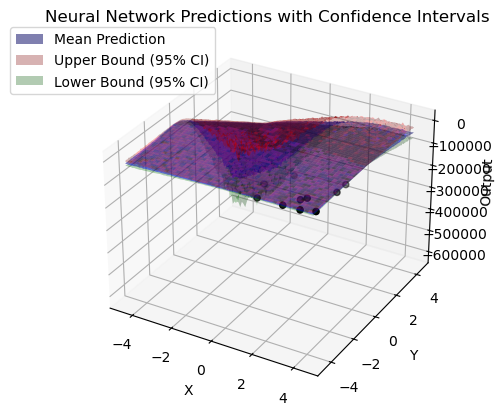

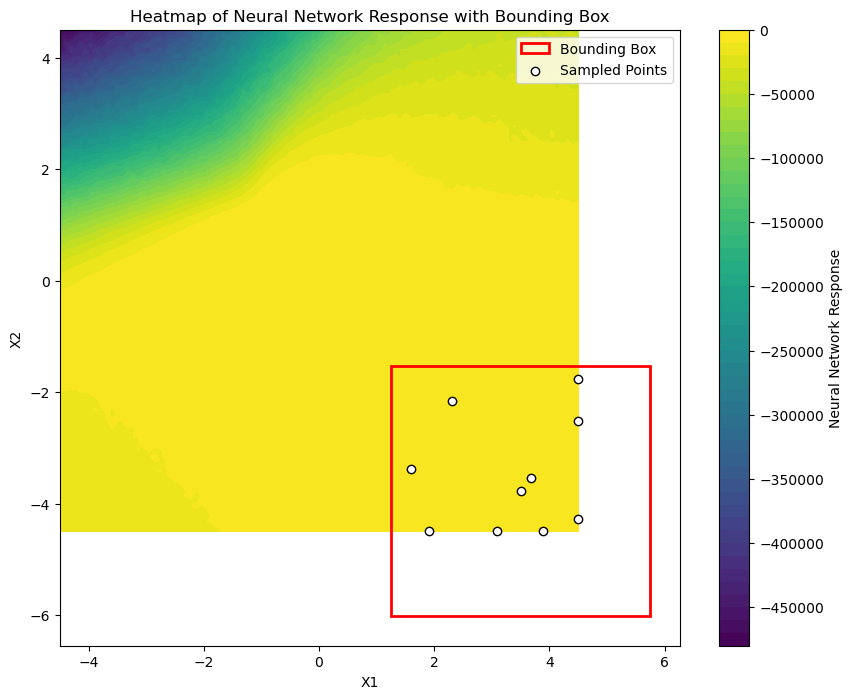

In [51]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [52]:
df_new2

x         y             z         a         b         sim_z  \
7  2.302965 -2.168187   -685.715519  4.402124 -3.092558   -685.754386   
8  4.500000 -1.766262   -970.192677  4.402124 -3.092558   -970.260145   
0  1.593906 -3.383712  -4074.472119  4.402124 -3.092558  -4074.595101   
2  4.500000 -2.524225  -6417.642883  4.402124 -3.092558  -6417.824240   
6  3.682017 -3.535553 -29044.719005  4.402124 -3.092558 -29044.948351   

       diff  
7  0.038867  
8  0.067468  
0  0.122982  
2  0.181357  
6  0.229345

In [53]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.402124 -3.092558 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.402124 -3.092558 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.402124 -3.092558  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.402124 -3.092558   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.402124 -3.092558   -70.288401  0.096751
5  2.657922 -0.309360    -3.921010  4.402124 -3.092558    -4.021214  0.100203
6  1.031095  0.255834    -4.672443  4.402124 -3.092558    -4.800469  0.128025
7 -0.436436  2.354488    -7.865382  4.402124 -3.092558    -7.899620  0.034238
8  0.709160  0.634130    -9.236444  4.402124 -3.092558    -9.274463  0.038019
9  0.772727  0.681818    -9.315922  4.402124 -3.092558    -9.347649  0.031727

In [54]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x         y             z         a         b         sim_z  \
0  -0.746802 -3.668953  -1695.133401  4.402124 -3.092558  -1695.119001   
1   1.982920 -2.823658  -2231.461373  4.402124 -3.092558  -2231.668855   
2  -4.498971 -1.389953   -522.757847  4.402124 -3.092558   -522.515883   
3  -1.779007 -0.929093    -64.660164  4.402124 -3.092558    -64.480989   
4  -3.179197  0.349351    -70.191649  4.402124 -3.092558    -70.288401   
5   2.657922 -0.309360     -3.921010  4.402124 -3.092558     -4.021214   
6   1.031095  0.255834     -4.672443  4.402124 -3.092558     -4.800469   
7  -0.436436  2.354488     -7.865382  4.402124 -3.092558     -7.899620   
8   0.709160  0.634130     -9.236444  4.402124 -3.092558     -9.274463   
9   0.772727  0.681818     -9.315922  4.402124 -3.092558     -9.347649   
10  2.302965 -2.168187   -685.715519  4.402124 -3.092558   -685.754386   
11  4.500000 -1.766262   -970.192677  4.402124 -3.092558   -970.260145   
12  1.593906 -3.383712  -4074.472119  4.402124 -3.092558  -4074.595101   
13  4.500000 -2.524225  -6417.642883  4.402124 -3.092558  -6417.824240   
14  3.682017 -3.535553 -29044.719005  4.402124 -3.092558 -29044.948351   

        diff  
0  -0.014399  
1   0.207481  
2  -0.241964  
3  -0.179175  
4   0.096751  
5   0.100203  
6   0.128025  
7   0.034238  
8   0.038019  
9   0.031727  
10  0.038867  
11  0.067468  
12  0.122982  
13  0.181357  
14  0.229345

In [55]:
df = df.iloc[:, :-4]
df

x         y             z
0  -0.746802 -3.668953  -1695.133401
1   1.982920 -2.823658  -2231.461373
2  -4.498971 -1.389953   -522.757847
3  -1.779007 -0.929093    -64.660164
4  -3.179197  0.349351    -70.191649
5   2.657922 -0.309360     -3.921010
6   1.031095  0.255834     -4.672443
7  -0.436436  2.354488     -7.865382
8   0.709160  0.634130     -9.236444
9   0.772727  0.681818     -9.315922
10  2.302965 -2.168187   -685.715519
11  4.500000 -1.766262   -970.192677
12  1.593906 -3.383712  -4074.472119
13  4.500000 -2.524225  -6417.642883
14  3.682017 -3.535553 -29044.719005

In [56]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new2['z'].max()],
                          "Round_num": [2]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [57]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.46651982 -2.95979202]


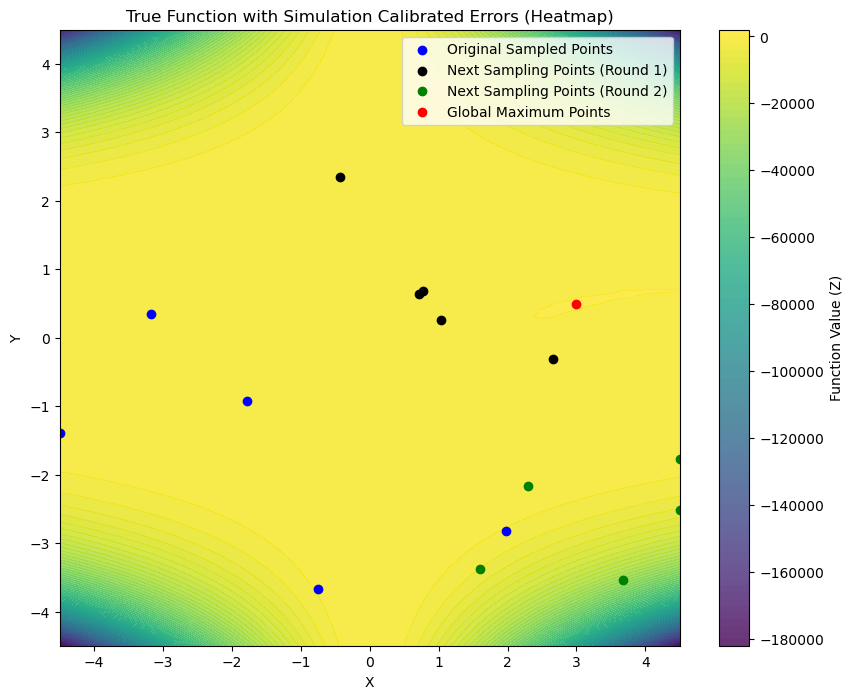

In [58]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [59]:
df_original

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.402124 -3.092558 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.402124 -3.092558 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.402124 -3.092558  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.402124 -3.092558   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.402124 -3.092558   -70.288401  0.096751

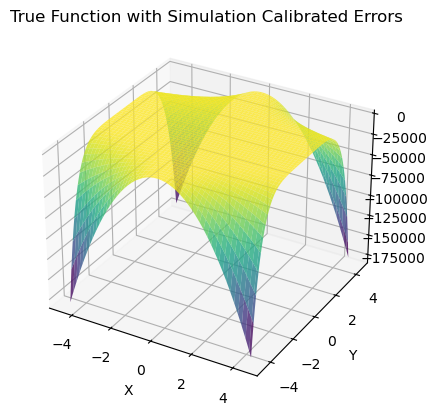

In [60]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [61]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -3.921010         1
2           -685.715519         2

In [62]:
df_new3 = pd.DataFrame

df_sim = df.copy()

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 60728448.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 60715892.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 60655256.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 60444416.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 59905404.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 58766020.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 55305028.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 53431900.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 47118520.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 41050836.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 39338624.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 34015576.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 41680028.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 329

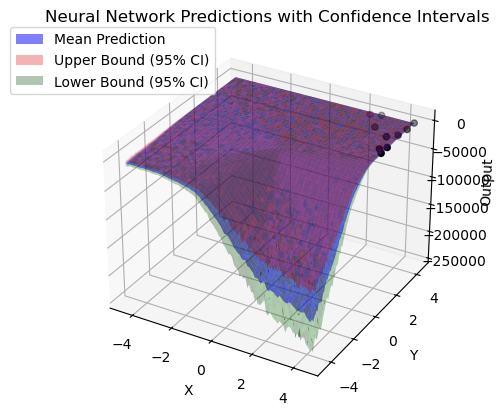

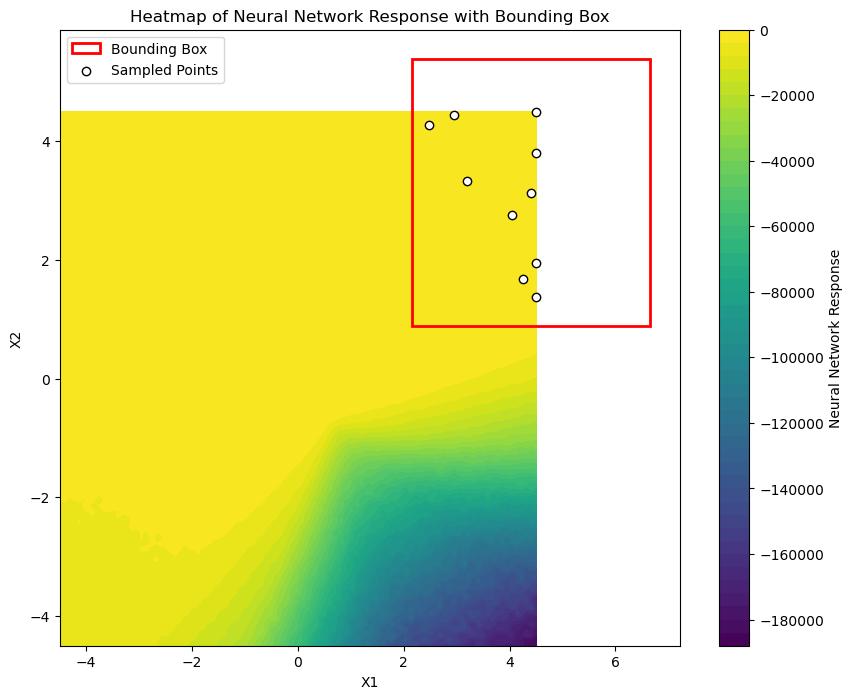

In [63]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1709549824.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1709496576.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1709219712.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1708324736.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1705671424.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1699775232.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1686423424.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1665003904.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1606851968.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1526822144.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1417360128.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1244892800.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1121848064.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━

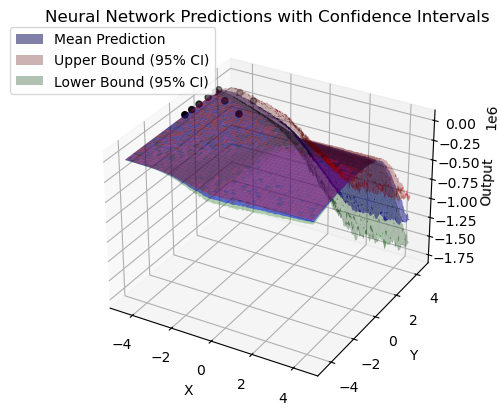

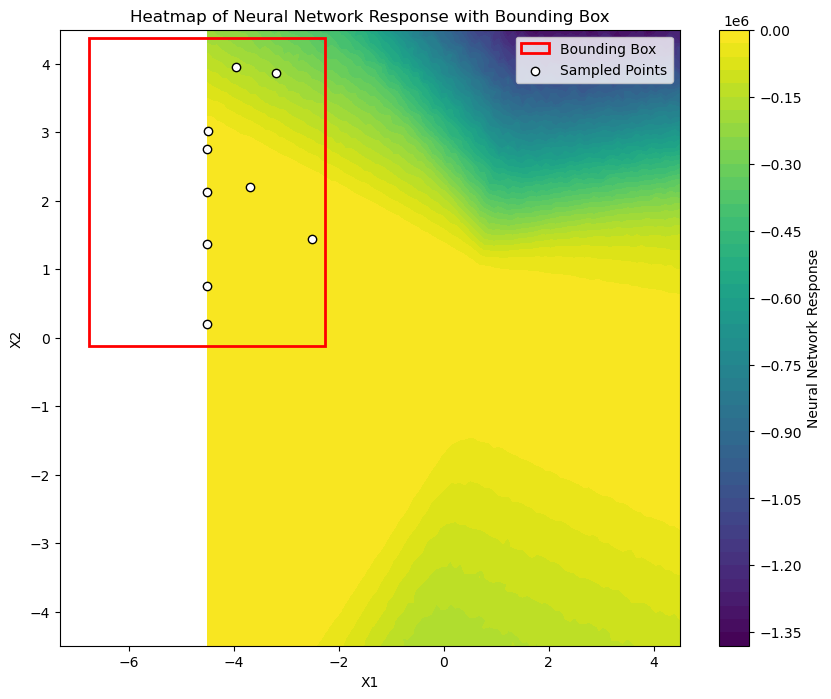

In [64]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1365374592.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1365339648.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1365137280.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1364509824.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1362743296.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1357706112.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1349150720.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1327348352.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1286333568.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1226985728.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1114813440.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 993847488.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 859953280.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 

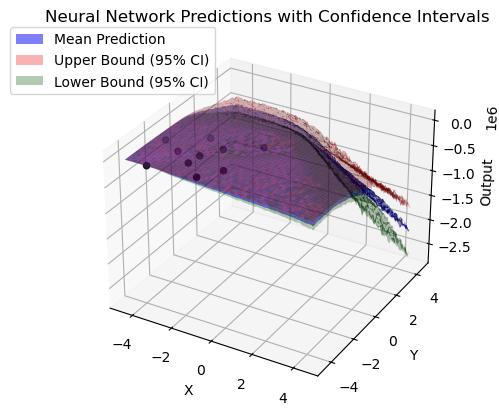

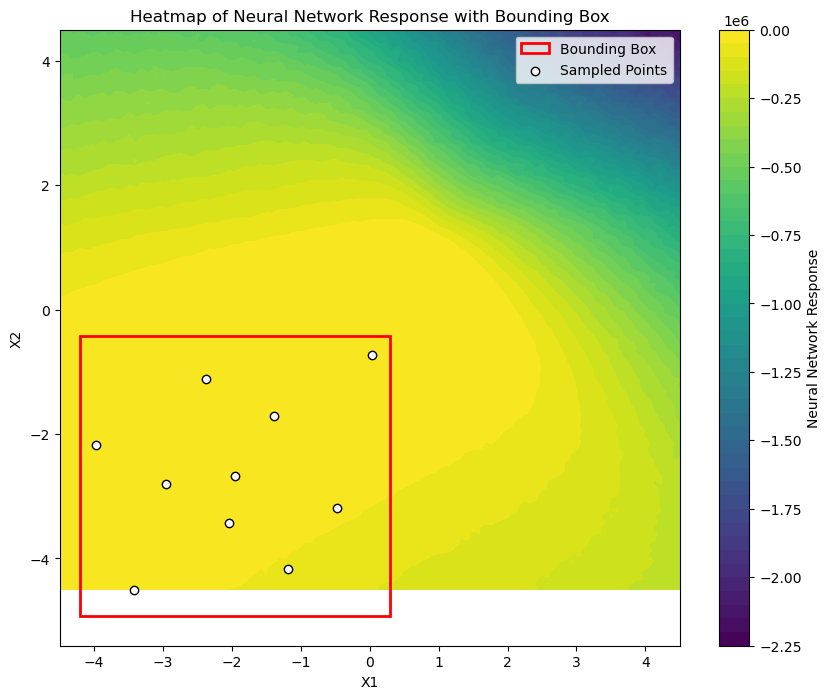

In [65]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1314213760.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1314164608.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1313941760.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1313106560.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1310609792.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1304237184.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1291091456.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1264557056.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1211663360.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1147637888.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1034603968.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 899660992.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 899464576.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 

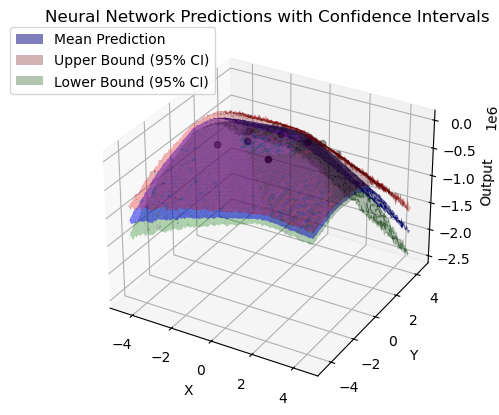

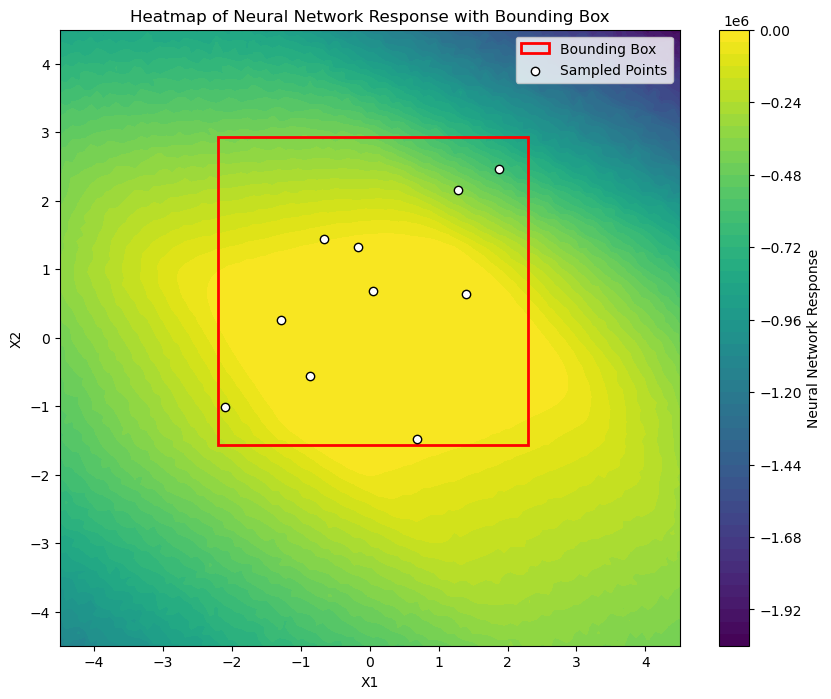

In [66]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1075288832.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1075248896.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1075086848.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1074458496.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1072622400.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1068813440.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1059683776.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1041324608.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1008332672.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 958102464.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 876080704.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 787604672.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 772235712.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

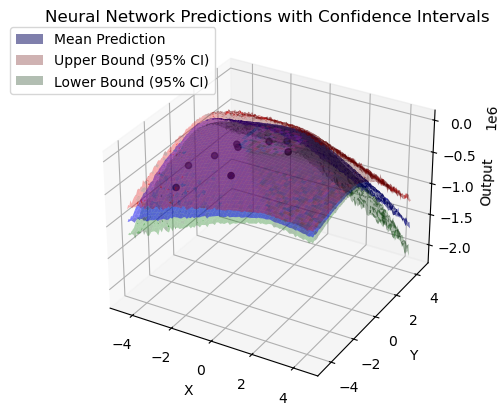

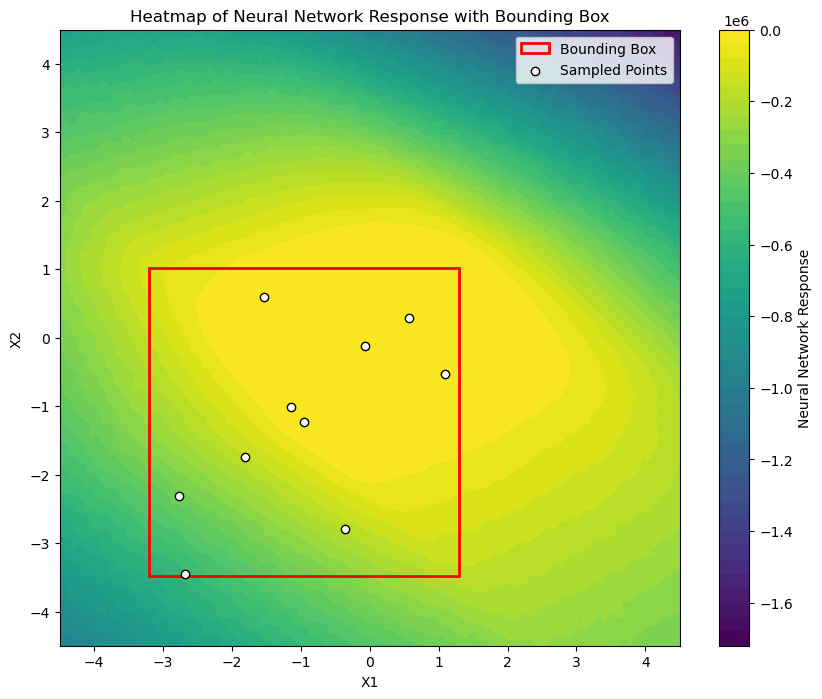

In [67]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 912955392.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 912896000.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 912658752.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 911641344.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 909004800.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 904111808.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 891203264.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 866833984.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 822114432.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 760466624.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 698467776.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 633074880.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 731682176.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste

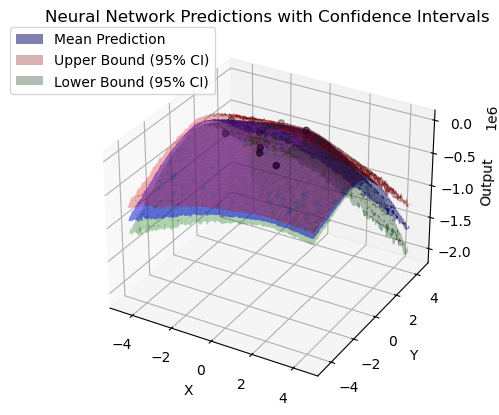

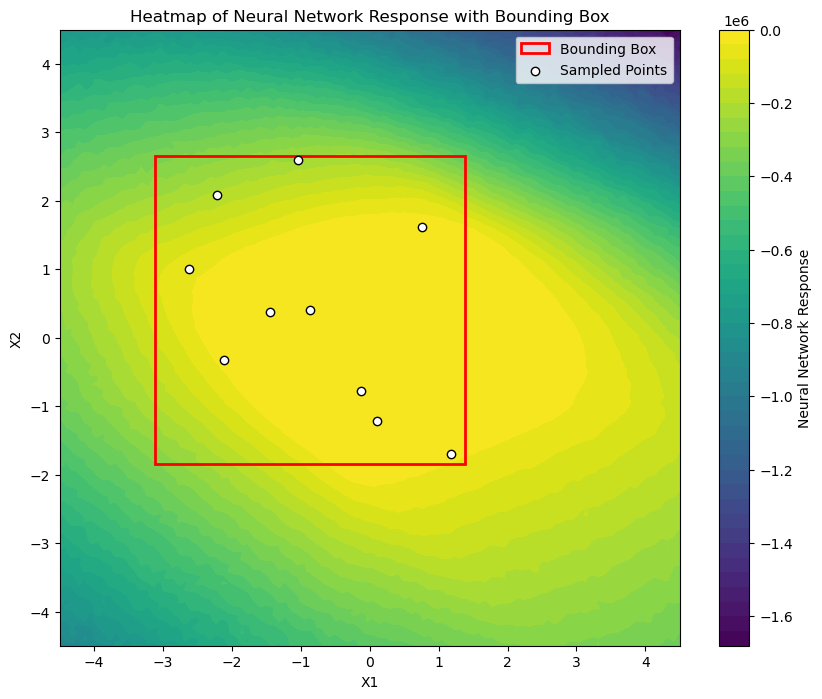

In [68]:
df_sim, df_new3 = perform_iteration(df_sim, df)

In [69]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new3['z'].max()],
                          "Round_num": [3]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [70]:
df = pd.concat([df, df_new3], ignore_index=True)

In [71]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32501889 -2.85488234]


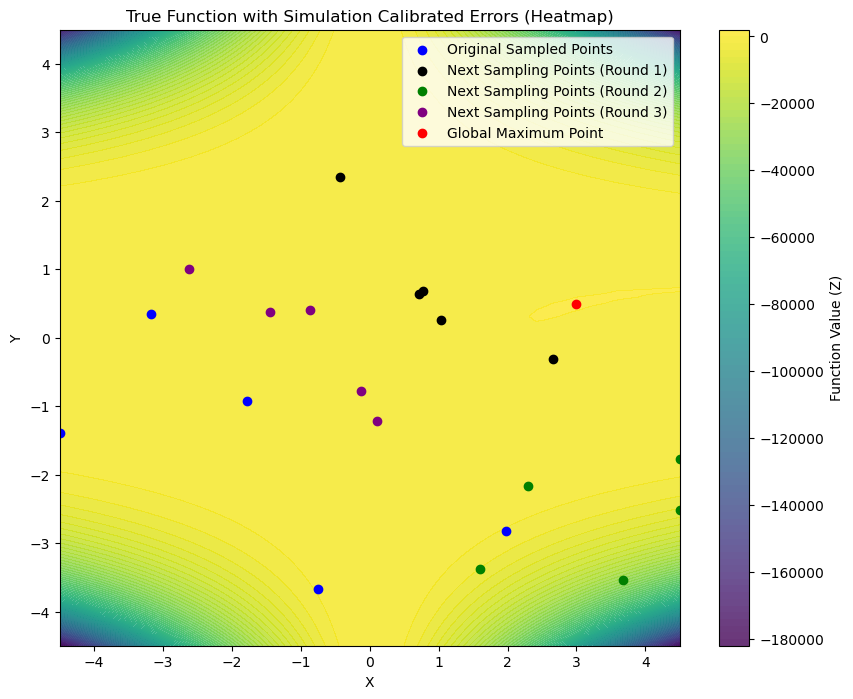

In [72]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [73]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -3.921010         1
2           -685.715519         2
3            -12.333670         3

In [74]:
df_new4 = pd.DataFrame

df_sim = df.copy()

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 45546392.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 45537068.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 45492440.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 45324124.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 45034272.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 43705736.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 42226904.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 39322000.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 34606144.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 29535396.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25776164.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27838708.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 28131020.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 232

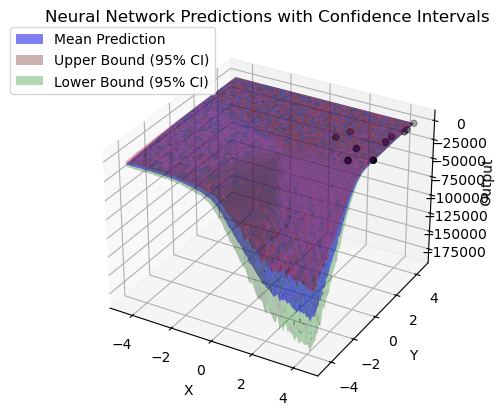

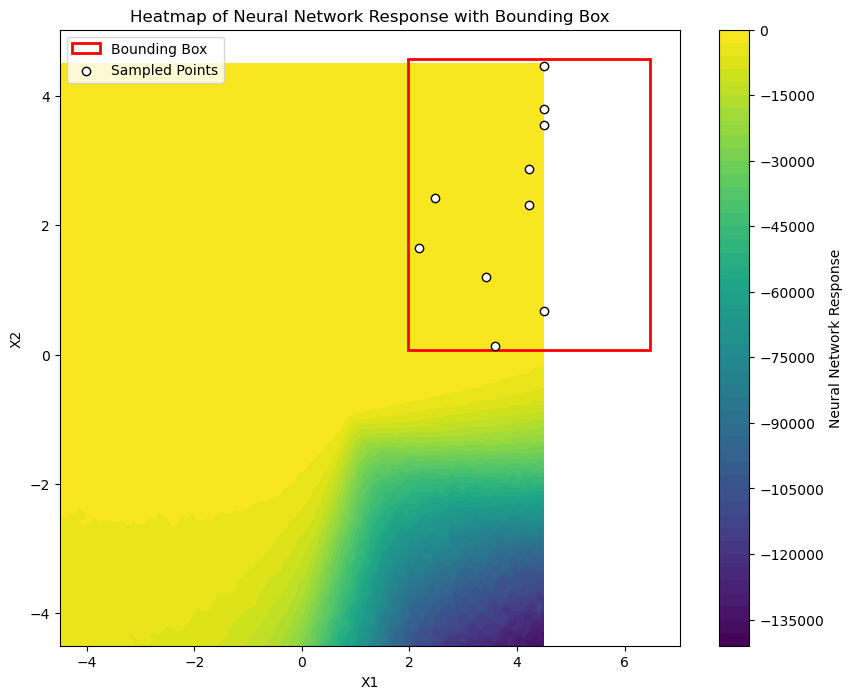

In [75]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1167570176.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1167552896.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1167487616.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1167316992.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1166740224.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1165029248.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1161767808.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1156113920.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1145089792.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1125943040.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1096256000.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1042816768.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 942433600.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━

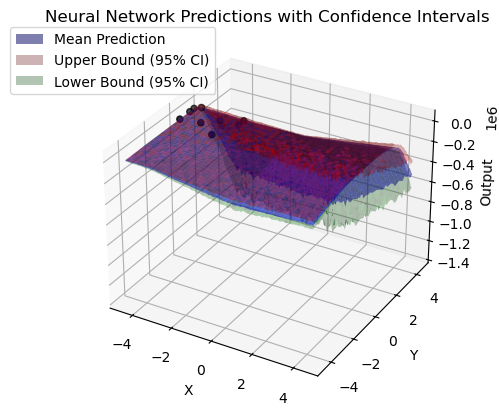

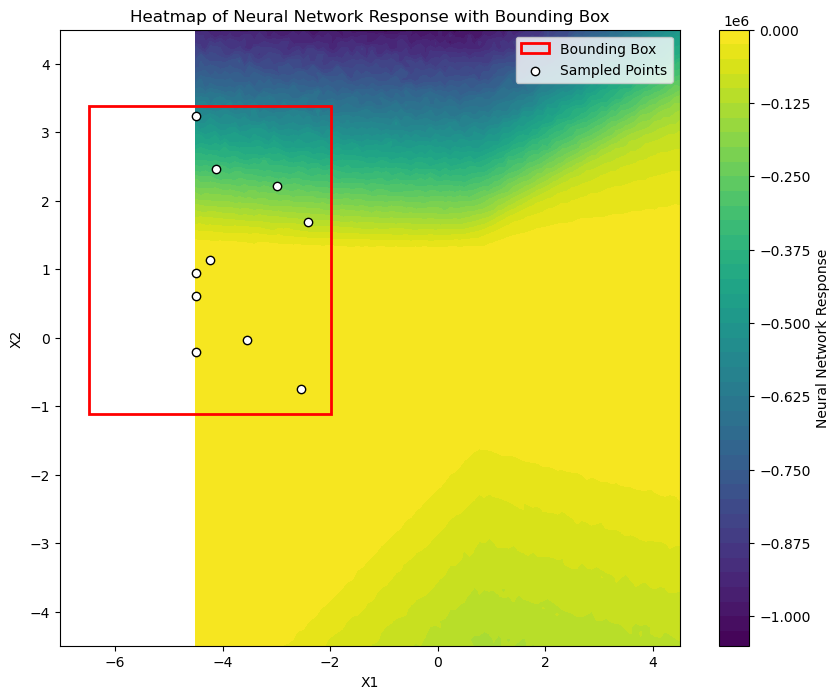

In [76]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 889499840.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 889425728.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 889117504.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 888195968.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 884575744.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 878384256.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 865132160.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 838592640.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 793631552.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 751886848.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 674337728.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 630040448.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 578094720.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/ste

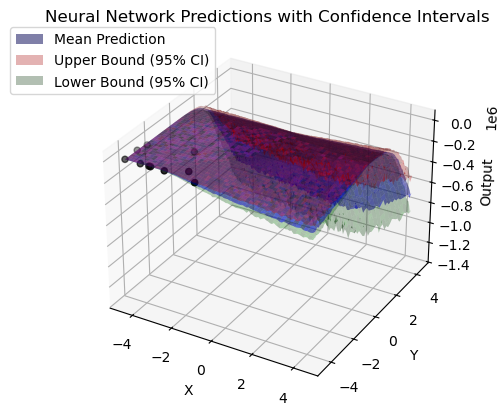

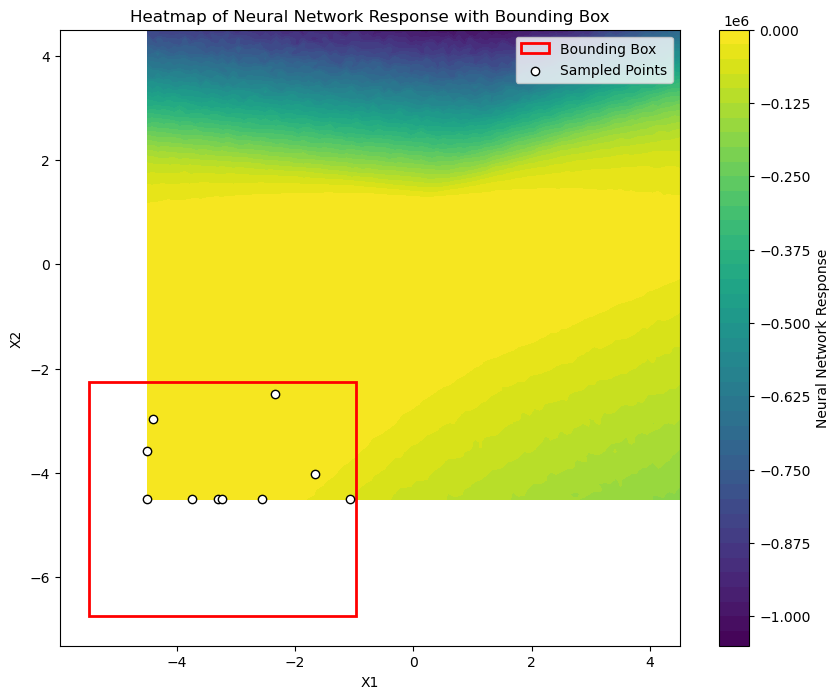

In [77]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2184446720.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2184350464.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2183904512.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2182213376.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2177415168.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2165517312.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2141341568.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2097479552.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2005223552.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1899361792.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1668774016.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1393086592.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1330263168.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━

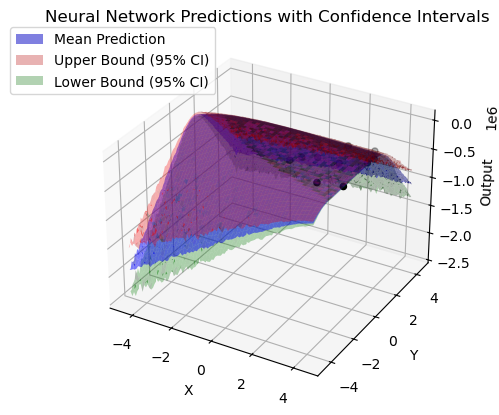

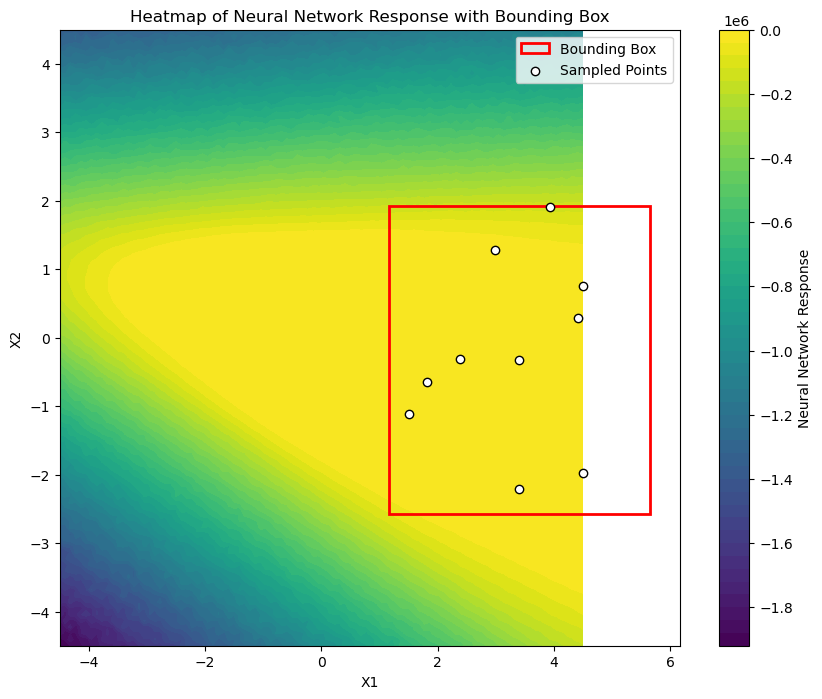

In [78]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Epoch 1/200


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1820481920.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1820366720.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1819872768.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1818059392.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1812459392.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1801012992.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1775434368.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1730349952.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1642142336.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1508486784.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1395459328.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1249905280.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1261820288.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

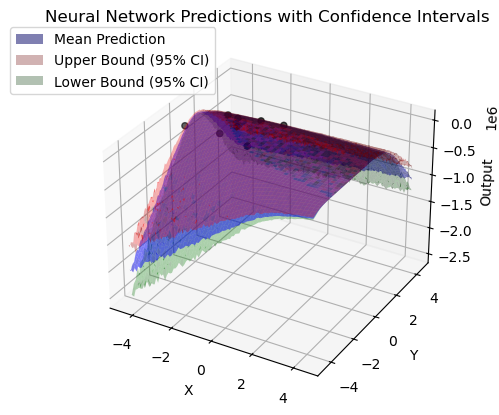

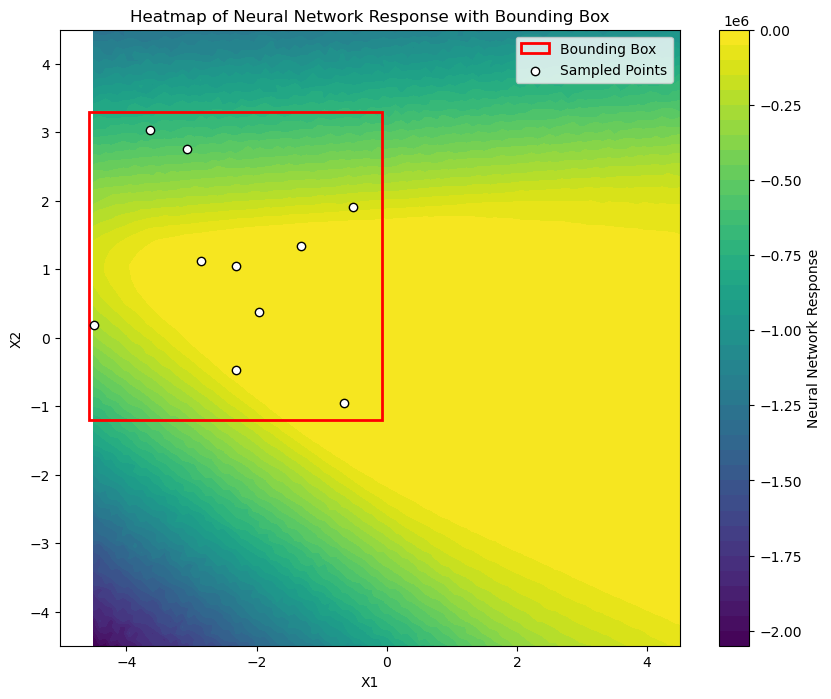

In [79]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1562041728.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1561962496.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1561641856.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1560393728.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1556858496.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1547947648.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1533036288.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1491730048.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1442596224.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1350079104.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1246682112.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1132100480.0000
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1035740800.0000
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━

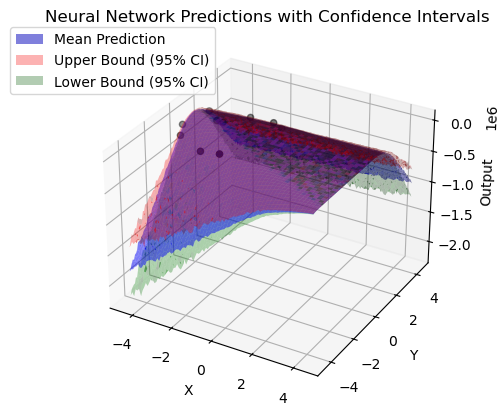

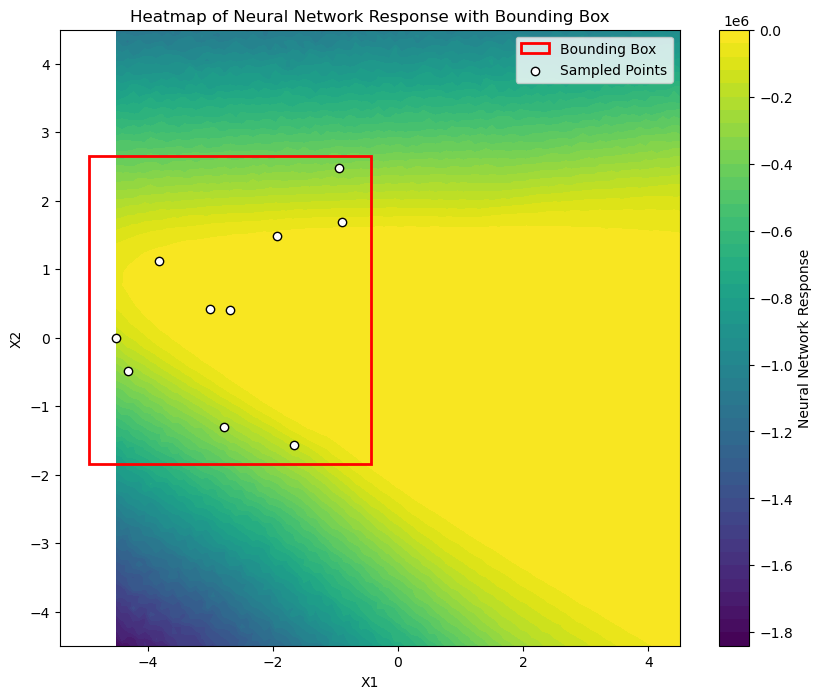

In [80]:
df_sim, df_new4 = perform_iteration(df_sim, df)

In [81]:
df = pd.concat([df, df_new4], ignore_index=True)

In [82]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new4['z'].max()],
                          "Round_num": [4]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [83]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.21621627 -2.86447133]


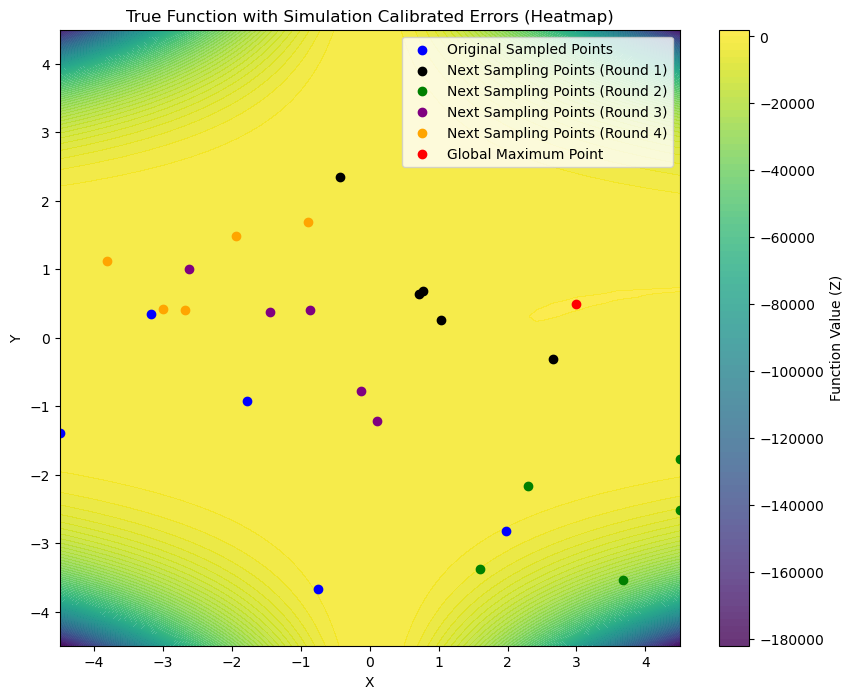

In [84]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')
ax.scatter(df_new4["x"], df_new4["y"], color='orange', marker='o', label='Next Sampling Points (Round 4)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [85]:
round_val_df.to_excel("NN2_round.xlsx", index=False) 

In [86]:
# Read the Excel file
file_path = "NN2_round.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

In [91]:
df

Highest_phy_Response  Round_num
0            -64.660164          0
1             -3.921010          1
2           -685.715519          2
3            -12.333670          3
4             -1.708504          4

In [92]:
data = {'Highest_phy_Response': [-64, -0.08, -0.905, -7.804, -10], 'Round_num': [0, 1, 2, 3, 4]}
df2 = pd.DataFrame(data)

In [95]:
df2

Highest_phy_Response  Round_num
0               -64.000          0
1                -0.080          1
2                -0.905          2
3                -7.804          3
4               -10.000          4

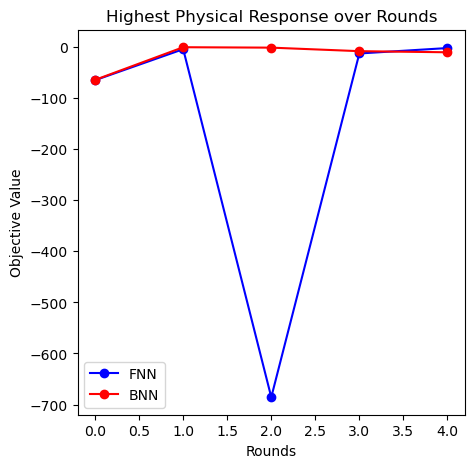

In [96]:
# Plotting
plt.figure(figsize=(5, 5))
plt.plot(df['Round_num'], df['Highest_phy_Response'], marker='o', linestyle='-', color='b',  label="FNN")
plt.plot(df2['Round_num'], df2['Highest_phy_Response'], marker='o', linestyle='-', color='r',  label="BNN")

# Labels and Title
plt.xlabel('Rounds')
plt.ylabel('Objective Value')
plt.title('Highest Physical Response over Rounds')
plt.legend()

# Show plot
plt.show()